# Problem set 10
## "The adventure of the 2001 dimensions"
### Zachary Miller

## Part 1: Verifying that PCA fails
Even though Moriarty is threatening to use our brain for his project, we know that using someones brain in your expirement is the highest form of flattery so we decide to help him. However, since we know that Moriarty is often wrong, we want to check for ourselves that PCA does not cluster the data well. Using our PCA function from last week and plotting below...

In [36]:
import numpy as np
import pandas as pd
import random
from scipy.spatial import distance
from scipy import linalg
from scipy import stats
from scipy import optimize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [32]:
def PCA(data_arr, n):
    """Takes in a non-standardized data array and performs PCA using SVD. Data should be in tidy format,
    with rows as observations and columns as variables"""
    
    num_rows = data_arr.shape[0]
    # Center the data
    centroid = np.mean(data_arr, axis=0)
    X_star = data_arr-centroid
    
    # Do SVD
    U, s, V_T = linalg.svd(X_star)
    eig_vectors = np.transpose(V_T)
    eig_vals = np.divide(s**2, num_rows-1)
    
    # Get the data projected into the number of PCA components specified
    PCA_data = np.matmul(X_star, eig_vectors[:,0:(n)])
    
    return PCA_data, eig_vectors, eig_vals, s, U, centroid

def plot_cluster_data(data, cluster_labels, plot_label_type, plot_title):
    """Plots data in two dimensions with colored clusters. Plot label type has the option to label the
    plot as a PCA plot if set to 'PCA', or just a generic plot label when set to None"""
    plt.figure(figsize=(15,15))
    
    clusters = np.unique(cluster_labels)
    
    if len(clusters) <= 16:
        colors = [ 'xkcd:red',    'xkcd:green',  'xkcd:magenta', 'xkcd:blue',
          'xkcd:purple', 'xkcd:orange', 'xkcd:cyan',    'xkcd:lime',
          'xkcd:pink',   'xkcd:yellow', 'xkcd:teal',    'xkcd:lavender',
          'xkcd:brown',  'xkcd:maroon', 'xkcd:olive',   'xkcd:navy' ]
        
    else:
        colors = cm.tab20(np.linspace(0, 1, len(clusters)))
    
    for cluster in clusters:
        plot_data_idx = (cluster_labels == cluster)
        plot_data = data[plot_data_idx,:]
        plt.scatter(plot_data[:,0], plot_data[:,1], marker='o', alpha=0.8, color=colors[cluster])
    
    if plot_label_type == "PCA":
        plt.title(plot_title)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        
    else:
        plt.title(plot_title)
        plt.xlabel("Axis 1")
        plt.ylabel("Axis 2")

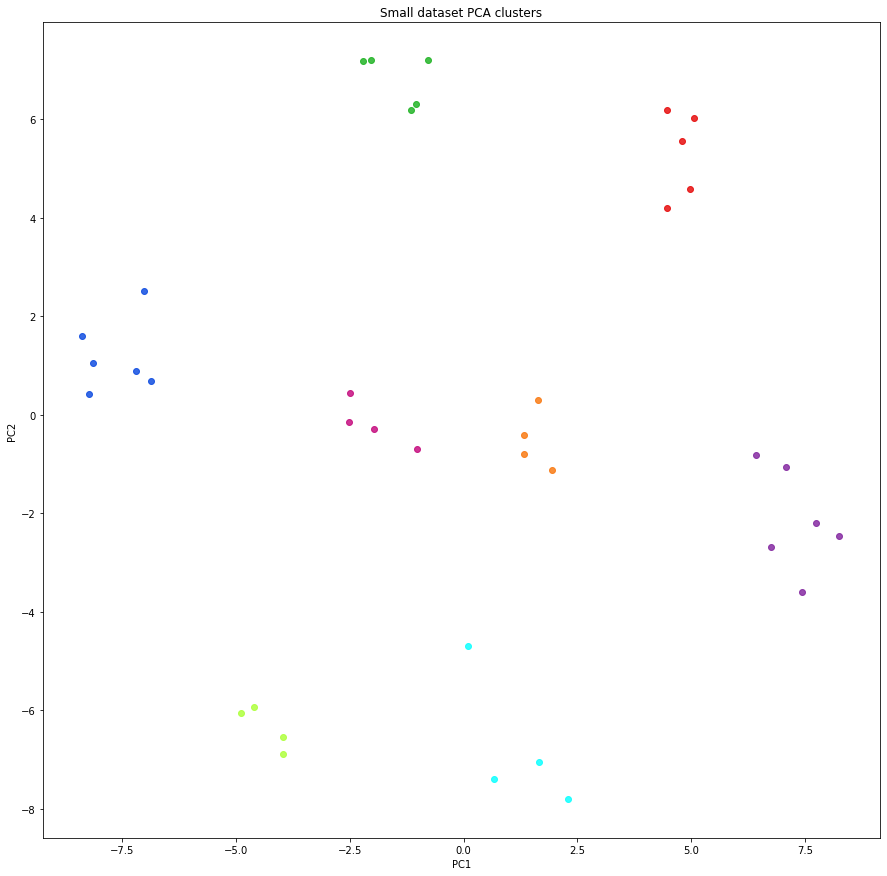

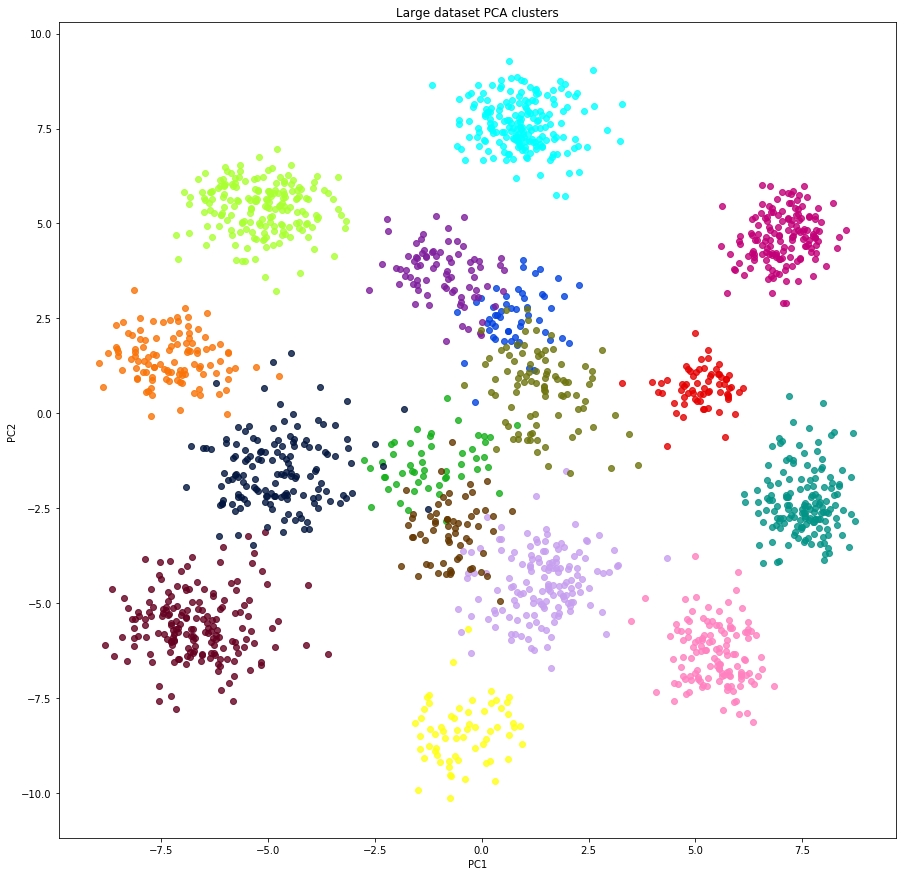

In [33]:
# Read in the small and large data sets, and take the log of the data (adding 1 to the data first to avoid
# domain errors)
small_data = pd.read_csv("w11-data-small.tbl", header=0, delim_whitespace=True)
small_data_labels = small_data["type"].values
small_log_counts = np.log(small_data.drop("type", axis=1).values+1)

large_data = pd.read_csv("w11-data-large.tbl", header=0, delim_whitespace=True)
large_data_labels = large_data["type"].values
large_log_counts = np.log(large_data.drop("type", axis=1).values+1)

# Run PCA on the data
small_PCA_vec = PCA(small_log_counts, 3)
small_PCA_data = small_PCA_vec[0]

large_PCA_vec = PCA(large_log_counts, 4)
large_PCA_data, large_PCA_eigvals = large_PCA_vec[0], large_PCA_vec[2]

# Plot the PCA data
plot_cluster_data(small_PCA_data, small_data_labels, plot_label_type="PCA", plot_title="Small dataset PCA clusters")
plot_cluster_data(large_PCA_data, large_data_labels, plot_label_type="PCA", plot_title="Large dataset PCA clusters")

We can see that for the small dataset PCA works out just fine, but for the large data set the clusters in the middle are not clearly differentiated. This likely means that there is likely a large amount of variance that is being captured in some higher dimensions. Let's check to see if that is the case by looking at the scree plot of the eigenvalues.

Text(0, 0.5, 'Eigenvalue')

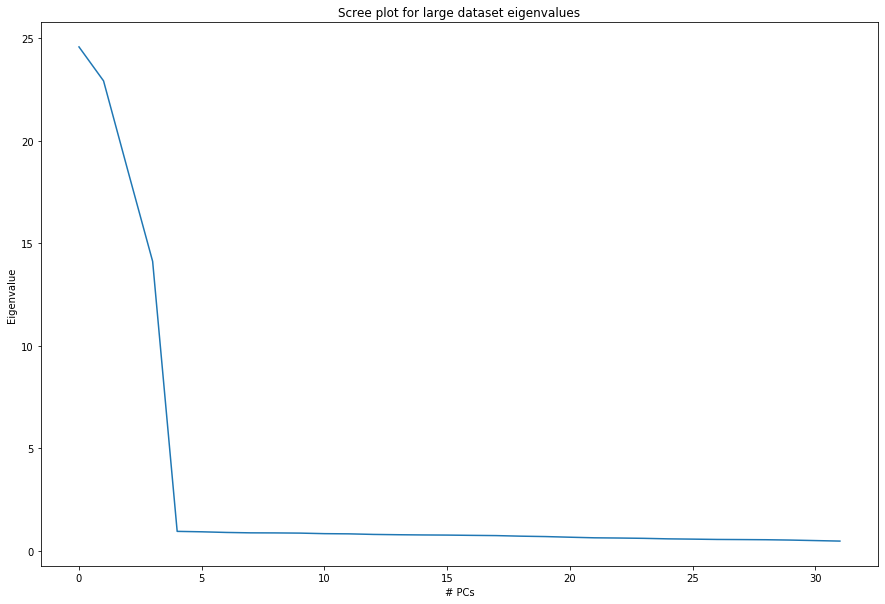

In [4]:
# Plot the scree plot for the large data set eigenvalues      
plt.figure(figsize=(15,10))
plt.plot(large_PCA_eigvals)
plt.title("Scree plot for large dataset eigenvalues")
plt.xlabel("# PCs")
plt.ylabel("Eigenvalue")

Looking at the scree plot, we can see that there is indeed a third PCA dimension that accounts for a significant amount of the variance. Therefore, when we try to project the data into only two dimensions, clusters begin to stack on top of each other and become unclear.

## Using t-SNE to visualize  the data
To visualize the data in only 2 dimensions, we can try to use a non-linear method like t-SNE. To impliment t-SNE, will first have to find the proper sigmas for our chosen perplexity value. We do this by restating the problem in terms of a root finding problem where our function is the perplexity as a function of sigma minus the desired perplexity for each point. We can then use optimize.bisect to find the sigma for which this desired perplexity is equal to the perplexity as a function of sigma. Then, we can use the KL distance between the p-dimensional points in the origional space and 2-dimensional points in t-SNE space as our objective function, and minimize this distance using optimize.minimize.

In van der Maaten and Hinton (2008), they make two reccomendations that I decided to change slightly given the size of this data set and the unsophisticated nature of scipy's optimize.minimize function. The first is the perplexity value. In the paper, they reccomend a perplexity value of around 30. However, since the small data set has only 38 points, this perplxity considers alost 3 quarters of all the points in the data set on average for each point, and therefore puts too much of an emphasis on global relatinships rather than local ones when creating the embedded data. So instead, we look at how well the different perplexities cluster the data with scipy's implementation of t-SNE. It looks like perplexities around 5 or 10 do best, so we will try our clustering with different perplexity values in that range. Another thing the paper reccomends is that we start with random embedded points generated from a $N(0,10^{-4})$ distribution. However, after a little expirementation with different initial conditions, I found that alowing the initial points to occupy a larger space, __finish__ with the small number of data points and the lack of tricks to avoid local optima available in optimize.minimize, I found that allowing the initial points to be in a larger space causes the optimizer to settle on local optimim far less often than for the very small initial conditions of the paper. 

In [5]:
def get_sigmas(perp, data, dist_mat):
    
    sigma_list = []
    for r_idx in range(data.shape[0]):
        
        dist_vec = dist_mat[r_idx].flatten()
        
        # Initialize the bracketing end points 
        a, b = 1, 1
        while sigma_cost_func(a, dist_vec, perp) >= 0: a /= 2
        while sigma_cost_func(b, dist_vec, perp) <= 0: b *= 2
            
        # Use scipy_bisect to find the best sigma for this row and store it
        sigma = optimize.bisect( sigma_cost_func, a, b, args=(dist_vec,perp) )
        sigma_list.append(sigma)
        
    return sigma_list

def sigma_cost_func(sigma, dist_vec, desired_perp):
    # find the diff between actual and desired perp for a given row's sigma
    
    p_vec = np.array([calc_p_numer(dist, sigma) for dist in dist_vec])
    p_vec = np.divide(p_vec, np.sum(p_vec)) # I removed the -1 because it does not work for the numerator
    
    pos_p_vec = p_vec[p_vec>0]
    H = -np.sum( np.asarray([p*np.log2(p) for p in pos_p_vec]) )
    
    actual_perp = 2**H
    
    return actual_perp-desired_perp

def calc_P_mat(dist_mat, sigma_vec):

        
    # Get all of the p_{j|i} into a nxn matrix 
    P_mat = np.asarray( [calc_p_numer(dist, sigma_vec[r_idx]) for r_idx in range(dist_mat.shape[0]) 
                       for dist in dist_mat[r_idx,:]] ).reshape(dist_mat.shape[0],dist_mat.shape[0])
    P_mat = np.divide(P_mat, P_mat.sum(axis=1))
    
    # Now create the symmetric probability matrix for T-SNE
    P_mat = np.divide( np.add(P_mat, np.transpose(P_mat)), 2*dist_mat.shape[0] )
 
    return P_mat
    
def calc_p_numer(dist, sigma):
    
    if dist == 0: return 0
    
    else: result = np.exp(-1*np.square(dist)/(2*np.square(sigma)))
    
    return result

In [6]:
def calc_KL_dist(Y_mat, P_mat):
    num_rows = P_mat.shape[0]
    Y_mat = Y_mat.reshape(num_rows, 2)
    
    dist_list = [distance.euclidean(row_1, row_2) for row_1 in Y_mat for row_2 in Y_mat]
    dist_mat = np.asarray(dist_list).reshape(num_rows, num_rows)
    
    # Get all of the q_{j|i} into a nxn matrix 
    
    #NOTE the distances squared are so small that they are basically zero, so all of the numerators are
    # then as you go to get the Q_mat, you end up with a nearly uniform matrix. This might be wrong, like
    # maybe we should use log calculations to keep track of the small initial differences
    Q_mat = np.true_divide( 1, (np.square(dist_mat)+1) )
    np.fill_diagonal(Q_mat, 0)
    Q_mat = np.true_divide( Q_mat, Q_mat.sum() ) # temp removed a subtract 1
    
    # Ignore divide by zero warnings when dividing by zero or taking the log, set all nans to zero to fix
    with np.errstate(divide="ignore", invalid="ignore"):
        KL_dist_mat = np.multiply( P_mat, np.log(np.true_divide(P_mat, Q_mat)) )
        KL_dist_mat = np.nan_to_num(KL_dist_mat)
        
    KL_dist = KL_dist_mat.sum()
    grad_list = []
    
    for i in range(num_rows):
        j_1_term_list = []
        j_2_term_list = []
        for j in range(num_rows):
            p_q_diff = P_mat[i,j] - Q_mat[i,j]
            y_1_diff = Y_mat[i,0] - Y_mat[j,0]
            y_2_diff = Y_mat[i,1] - Y_mat[j,1]
            y_dist = np.true_divide( 1, 1+np.square(dist_mat[i,j]) )
            
            j_1_term_list.append( p_q_diff*y_1_diff*y_dist )
            j_2_term_list.append( p_q_diff*y_2_diff*y_dist )
            
        grad_list.append(4*sum(j_1_term_list))
        grad_list.append(4*sum(j_2_term_list))
        
    return KL_dist, np.asarray(grad_list).flatten()

In [134]:
dist_list = [distance.euclidean(row_1, row_2) for row_1 in small_log_counts for row_2 in small_log_counts]
dist_mat = np.asarray(dist_list).reshape(small_log_counts.shape[0], small_log_counts.shape[0])

sigma_list = get_sigmas(10, small_log_counts, dist_mat)

P_mat = calc_P_mat(dist_mat, sigma_list)

In [135]:
print(sigma_list)

[3.74151800138452, 4.264243751366621, 3.616727512057423, 4.2261332583782405, 3.733217457644514, 4.206897681535565, 3.7402926383842896, 3.98079375320458, 4.150276106442789, 4.068522746309782, 3.8661905942230987, 3.849932874746173, 4.064261933035823, 3.672519162081244, 3.592742666484355, 4.41597633280503, 3.8629067859687893, 4.136136011815552, 4.156962611251629, 3.7706308058754985, 4.048018166043903, 3.865935674987213, 4.263171305183505, 4.044178479537322, 4.106078730074614, 4.0784878831939295, 4.081924865948849, 3.850176967346215, 3.995961570142299, 3.875577636786602, 4.259565929615064, 4.149366864606463, 3.66206231775368, 4.013625222329438, 4.109116283929097, 3.981977263384124, 4.1089540862092235, 4.10632444574162]


In [141]:
#NOTE this is not actually getting any smaller. Need to check the gradient function to make sure it 
# correct. After that, check the calculation of the KL_dist *FIXED*

#NOTE I checked the gradient using check_grad, was within e-6 so I don't think that is the problem
best = 100
vals = -1

for i in range(20):
    Y_mat = np.random.normal( 0., 1, (38, 2) )
    result = optimize.minimize(calc_KL_dist, Y_mat.flatten(), args=(P_mat), jac=True)
    
    if result.fun <= best:
        best = result.fun
        vals = result.x
        print(result.message)
        print(best)


Desired error not necessarily achieved due to precision loss.
0.20860955454201477
Desired error not necessarily achieved due to precision loss.
0.17841031750548336
Desired error not necessarily achieved due to precision loss.
0.14818437388996336
Desired error not necessarily achieved due to precision loss.
0.14556237974856584
Desired error not necessarily achieved due to precision loss.
0.14362806249177895


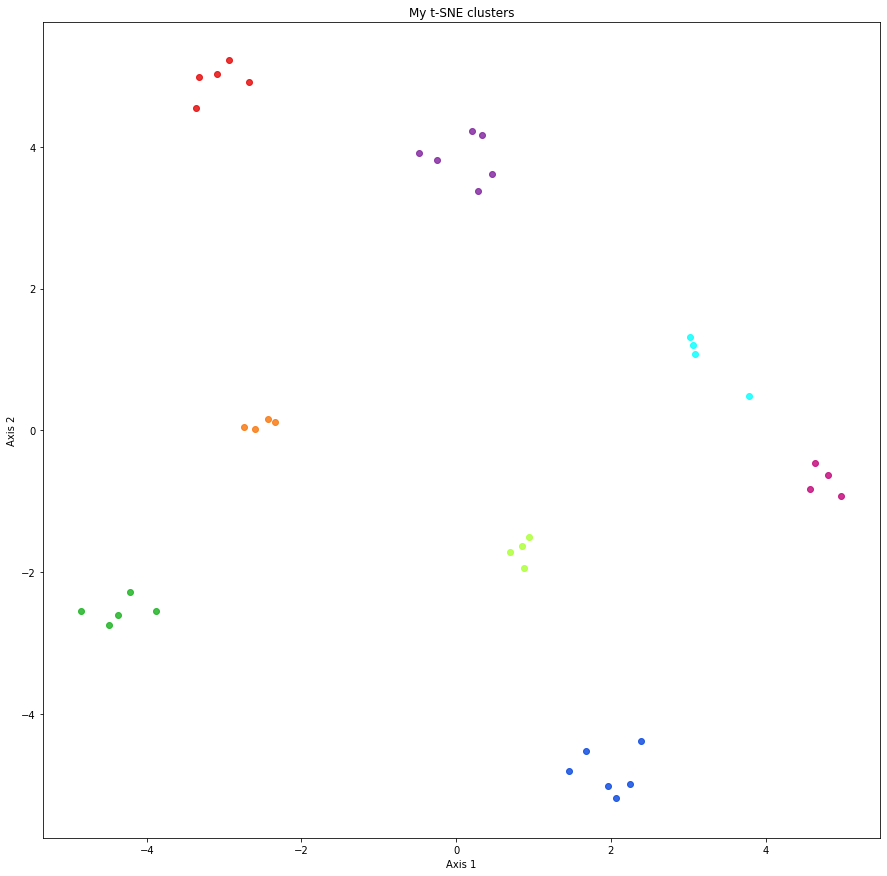

In [142]:
vals = vals.reshape(38,2)
plot_cluster_data(vals, small_data_labels, plot_label_type=False, plot_title="My t-SNE clusters")

## Part 3

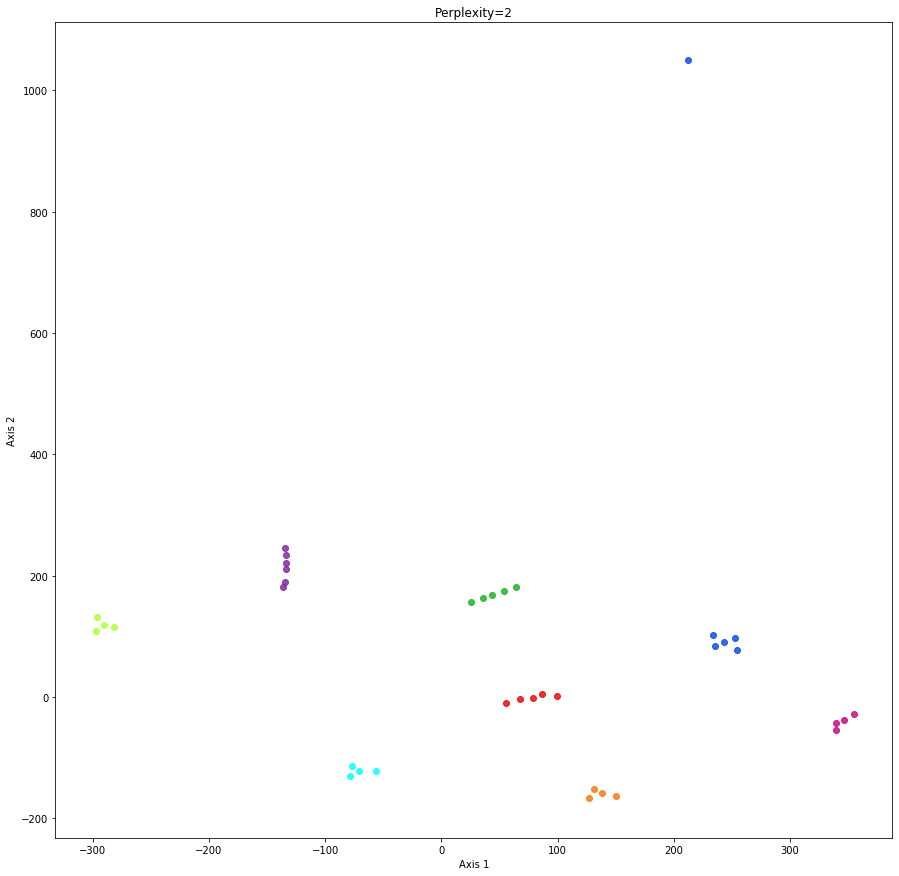

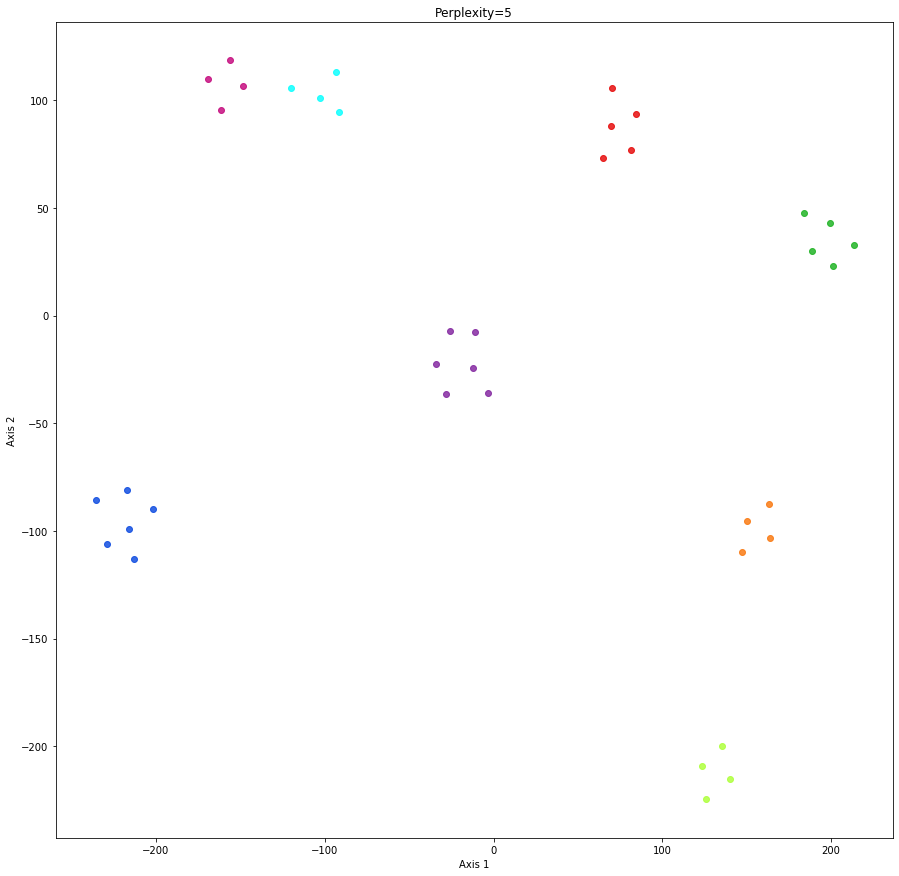

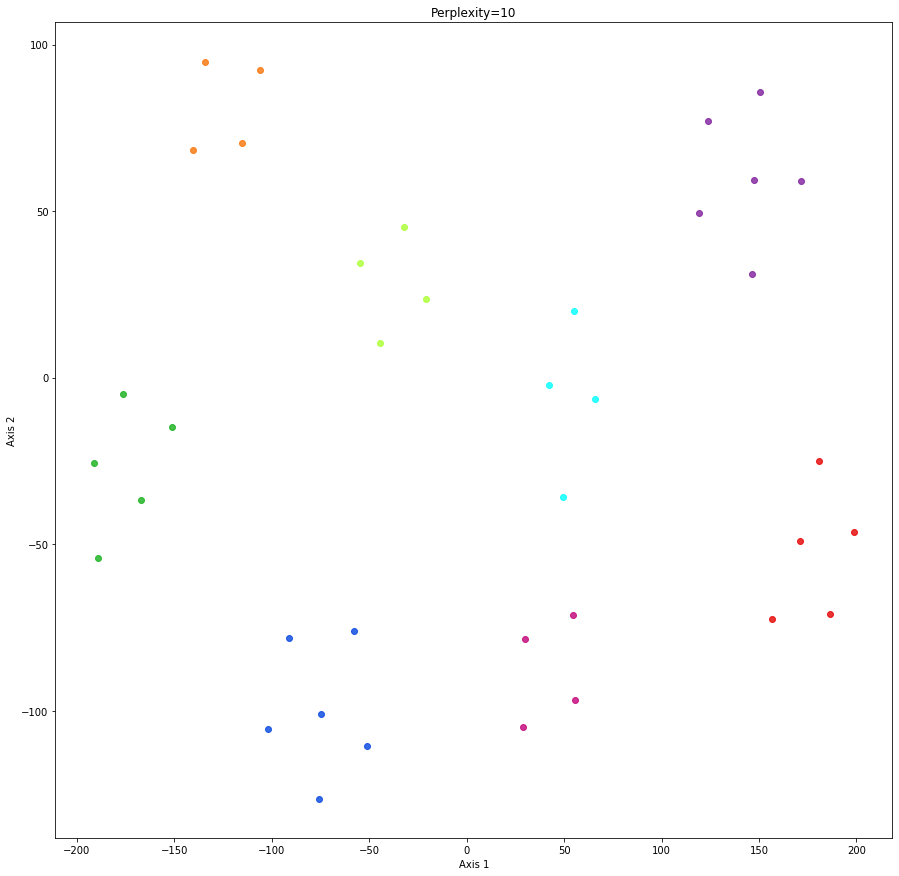

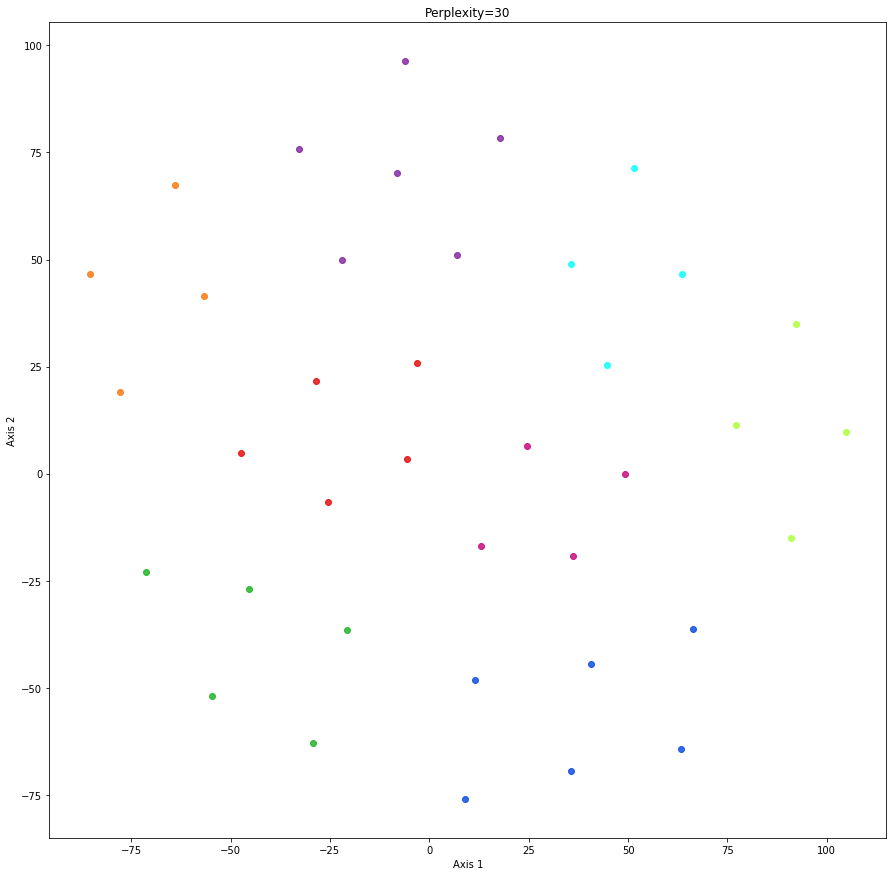

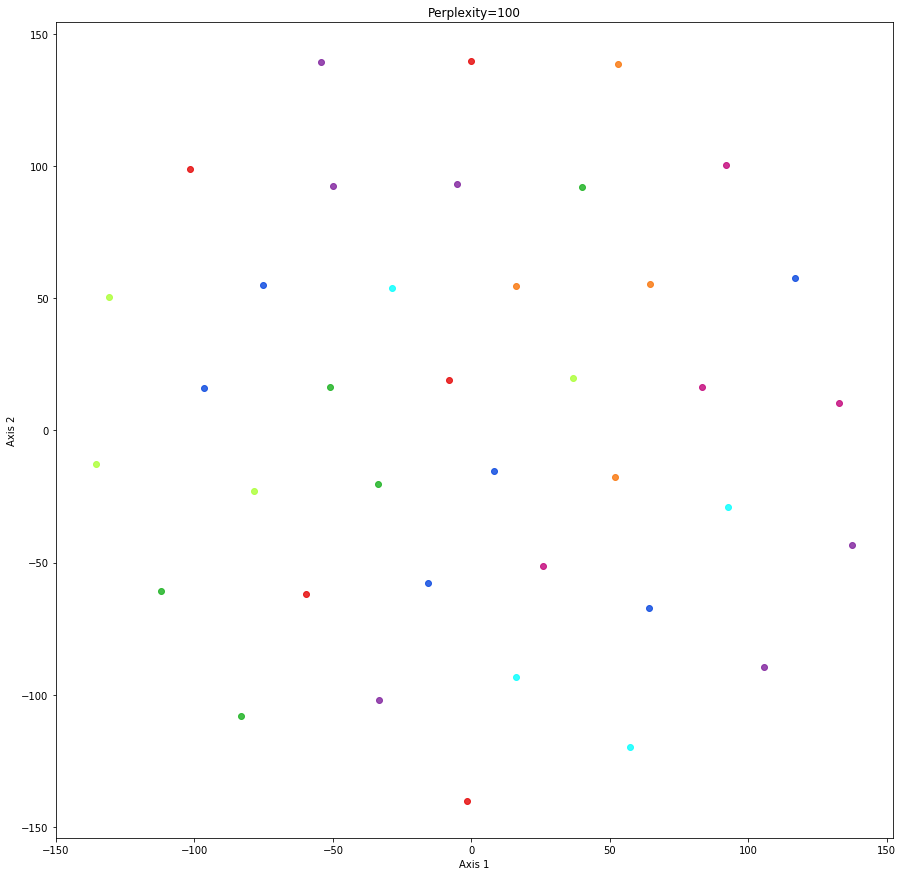

In [37]:
small_plot_2 = TSNE(perplexity=2).fit_transform(small_log_counts)
small_plot_5 = TSNE(perplexity=5).fit_transform(small_log_counts)
small_plot_10 = TSNE(perplexity=10).fit_transform(small_log_counts)
small_plot_30 = TSNE(perplexity=30).fit_transform(small_log_counts)
small_plot_100 = TSNE(perplexity=100).fit_transform(small_log_counts)
plot_cluster_data(small_plot_2, small_data_labels, plot_label_type=False, plot_title="Perplexity=2")
plot_cluster_data(small_plot_5, small_data_labels, plot_label_type=False, plot_title="Perplexity=5")
plot_cluster_data(small_plot_10, small_data_labels, plot_label_type=False, plot_title="Perplexity=10")
plot_cluster_data(small_plot_30, small_data_labels, plot_label_type=False, plot_title="Perplexity=30")
plot_cluster_data(small_plot_100, small_data_labels, plot_label_type=False, plot_title="Perplexity=100")

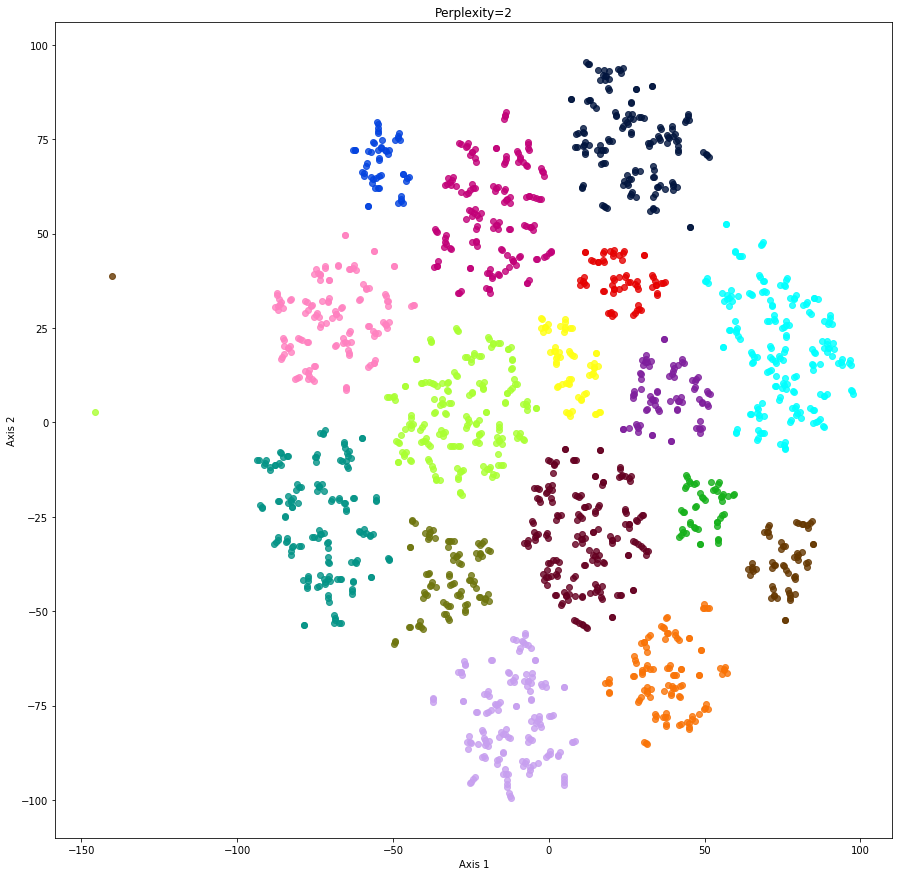

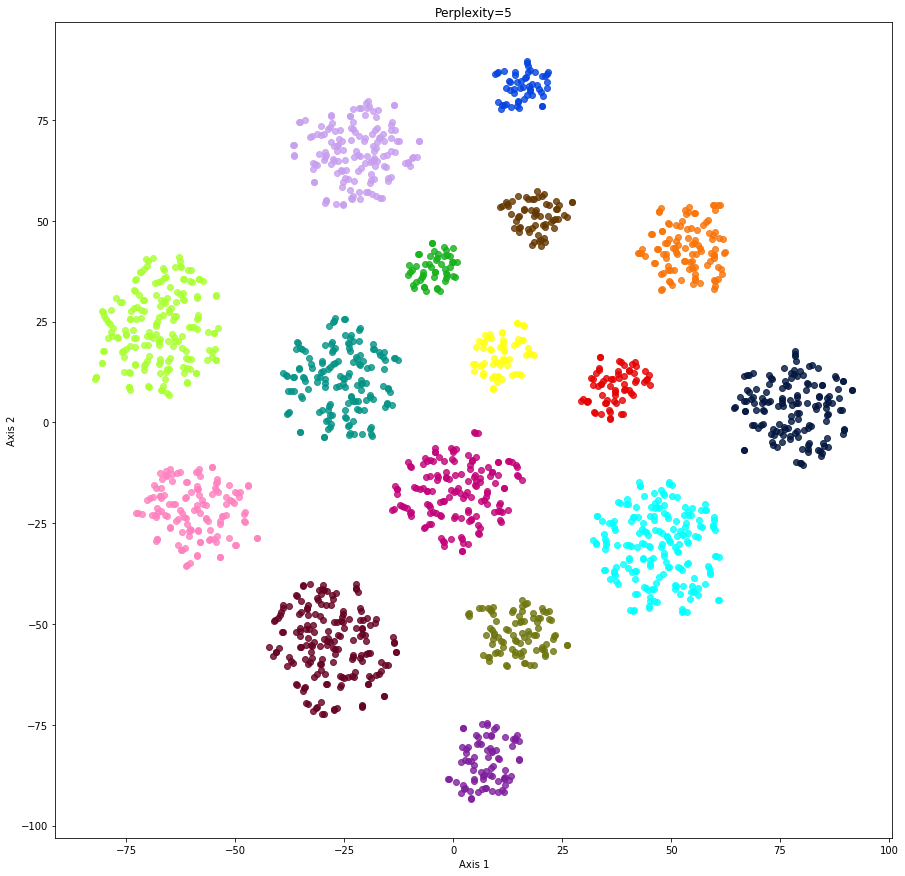

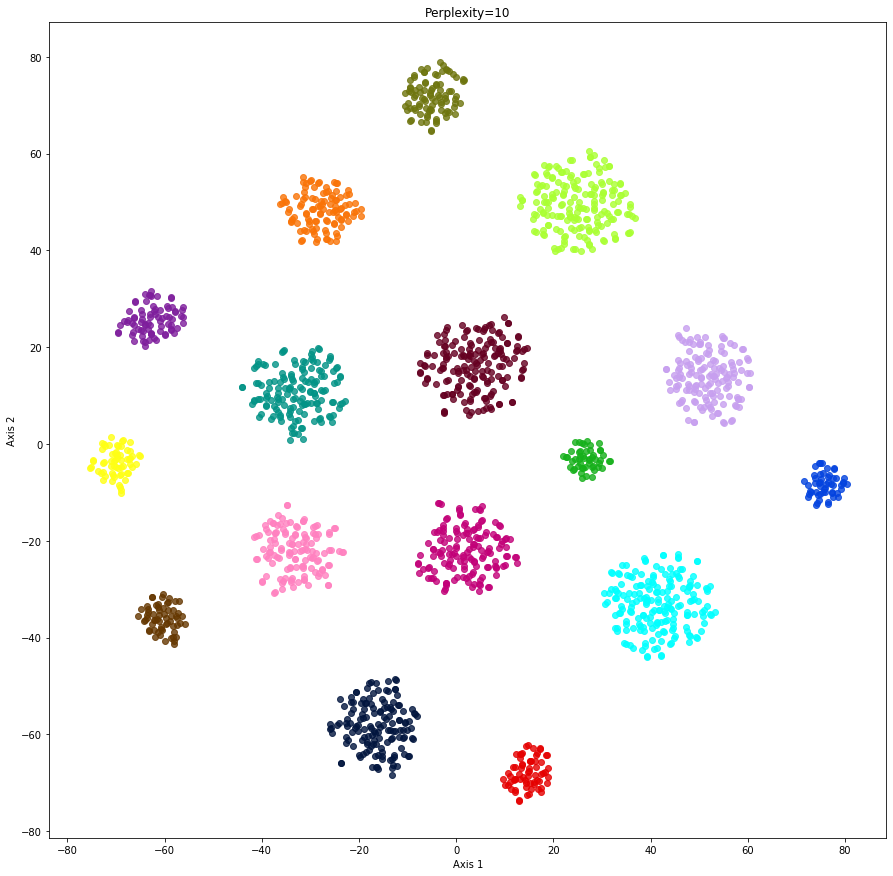

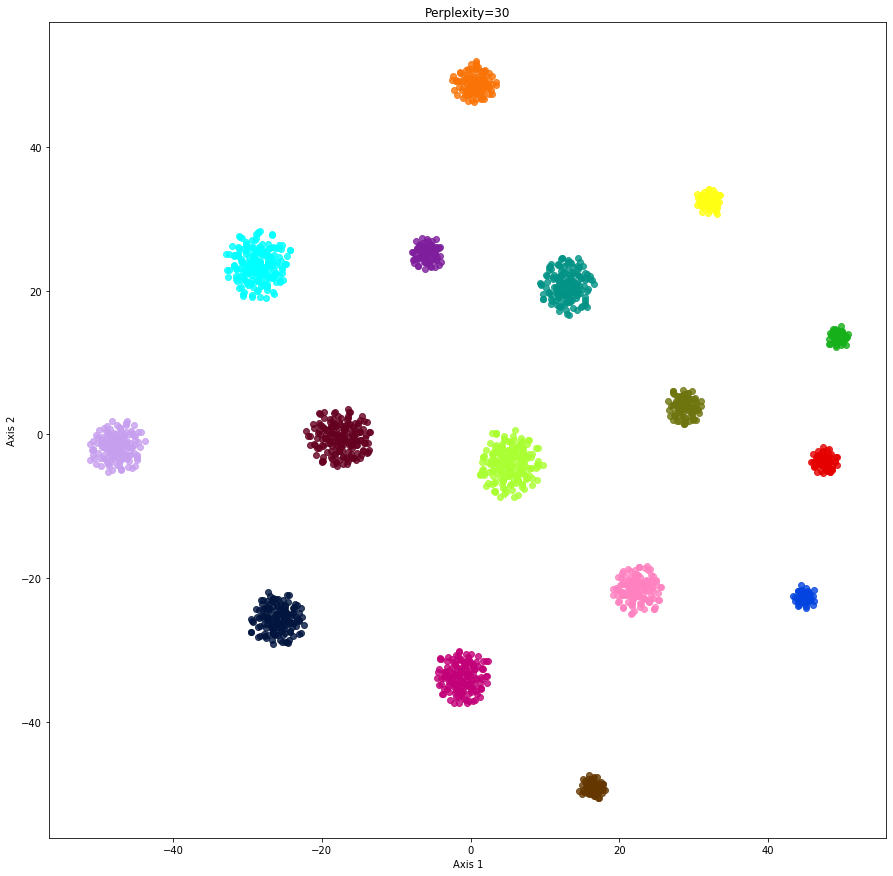

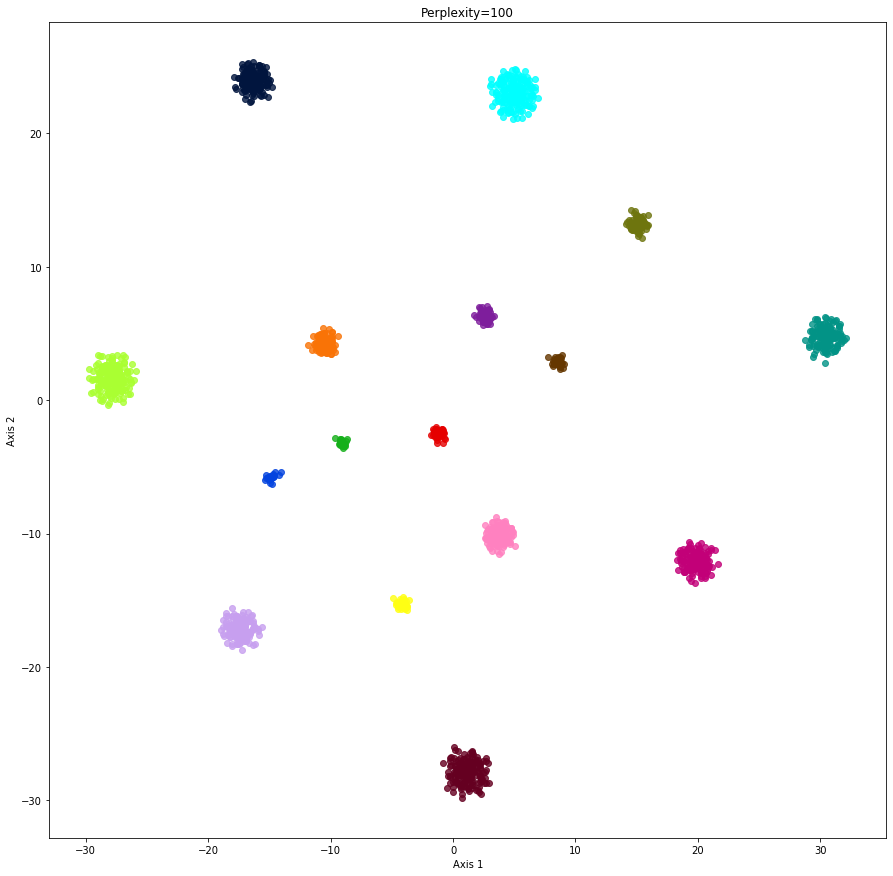

In [39]:
large_plot_2 = TSNE(perplexity=2).fit_transform(large_log_counts)
large_plot_5 = TSNE(perplexity=5).fit_transform(large_log_counts)
large_plot_10 = TSNE(perplexity=10).fit_transform(large_log_counts)
large_plot_30 = TSNE(perplexity=30).fit_transform(large_log_counts)
large_plot_100 = TSNE(perplexity=100).fit_transform(large_log_counts)
plot_cluster_data(large_plot_2, large_data_labels, plot_label_type=False, plot_title="Perplexity=2")
plot_cluster_data(large_plot_5, large_data_labels, plot_label_type=False, plot_title="Perplexity=5")
plot_cluster_data(large_plot_10, large_data_labels, plot_label_type=False, plot_title="Perplexity=10")
plot_cluster_data(large_plot_30, large_data_labels, plot_label_type=False, plot_title="Perplexity=30")
plot_cluster_data(large_plot_100, large_data_labels, plot_label_type=False, plot_title="Perplexity=100")